# Cardiovascular Disease-Heart Failure Predictions 
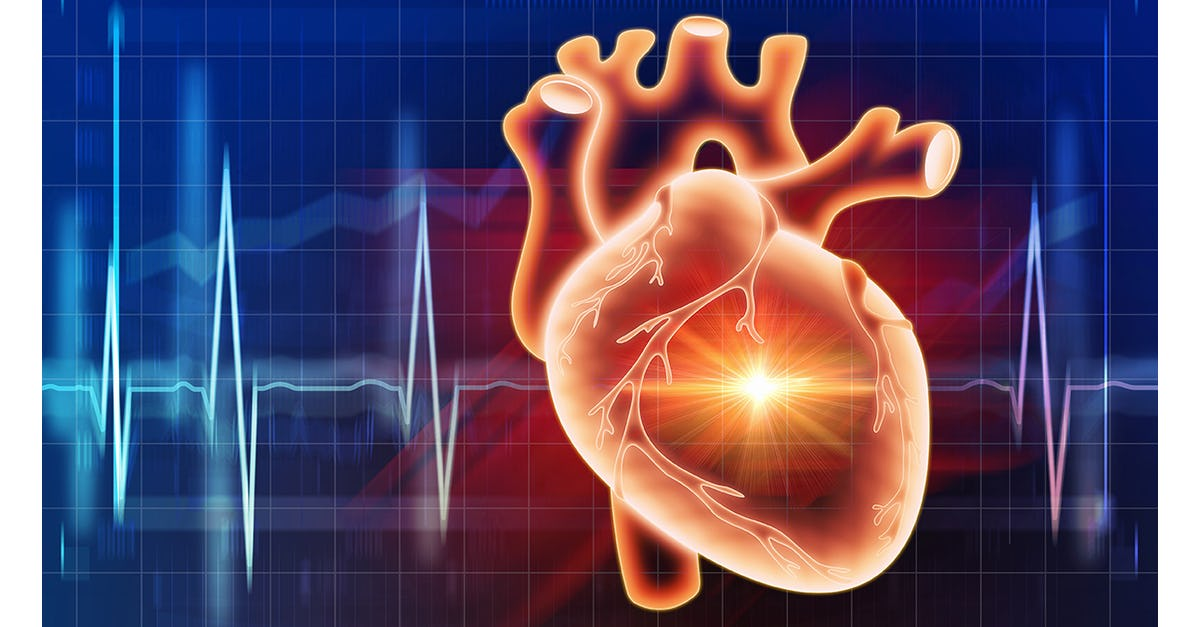

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5 CVD deaths are due to heart attacks and strokes, and 1/3 of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

## Data Description
Source: https://www.kaggle.com/fedesoriano/heart-failure-prediction

|Features| Description| Measurements [Range]|
|:- |:-|:-|
| Age            | Age of the patient                   | Years [28..77] |
| Sex            | Sex of the patient                   | M, F|
| ChestPainType  | chest pain type                      | TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic|
| RestingBP      | resting blood pressure               | mmHg [0..200]|
| Cholesterol    | serum cholesterol                    | mm/dl [0..603]|
| FastingBS      | fasting blood sugar                  | 1: if FastingBS > 120 mg/dl, 0: otherwise|
| RestingECG     | resting electrocardigogram results   | Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria |
| MaxHR          | Maximum heart rate achieved          | [60..202]|
| ExerciseAngina | exercise-induced angina              | Y, N|
| Oldpeak        | oldpeak=ST                           | Numeric value measured in depression [-2.6..6.2]|
| ST_Slope       | Slope of the peak exercise ST segment| Up:upsloping, Flat:flat, Down:downsloping|
| HeartDisease   | Output class                         | 1:heart disease, 0:normal|


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score

matplotlib.style.use('fivethirtyeight')
sns.set(style = "whitegrid")

## Import Dataset

In [2]:
data = pd.read_csv('heart.csv')
print(data.shape)
data.head(10)

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


It's obvious that our target column is __HeartDisease__ column

In [4]:
target = 'HeartDisease'

## Annotation for barplot function

In [5]:
def bar_annotations(ax, spacing = 5):

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        plt.annotate(
            label,                        # Use `label` as label
            (x_value, y_value),           # Place label at end of the bar
            xytext = (0, space),          # Vertically shift label by `space`
            textcoords = "offset points", # Interpret `xytext` as offset in points
            ha = 'center',                # Horizontally center label
            va = va)                      # Vertically align label differently for positive and negative values.

## Explore categorical columns

We will look into object-dtyped columns since these are categortical features. __FastingBS__ is also an categorical features (its value is either 0 or 1) so we need to convert this column to object.

In [6]:
data['FastingBS'] = data['FastingBS'].astype('object')

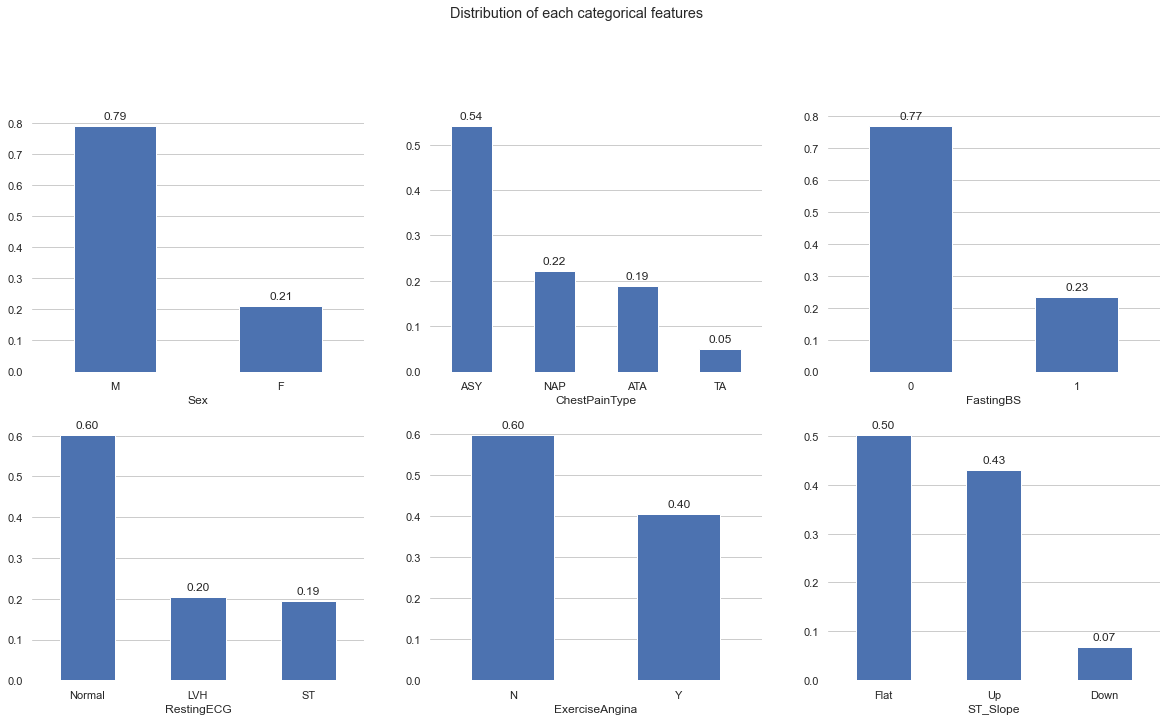

In [7]:
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
fig = plt.figure(figsize=(18,15))
fig.suptitle('Distribution of each categorical features')
for i,col in enumerate(categorical_cols):
    plt.subplot(3,3,i+1)
    ax = data[col].value_counts(normalize=True).plot.bar(rot=0)
    ax.set_xlabel(col)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.xaxis.grid(False)
    bar_annotations(ax)
plt.show()   

__Observations__:

1. There are ~80% of more males while only 21% female in the dataset. This may or may not affect out model's performance later on.
2. The majority of chest pain type is ASY(54%).

3. About 77% patient has fasting blood sugar > 120 mg/dl.

4. About 60% has normal resting ECG.

5. The majority (93%) of patient has Flat and Up ST_Slope

Let's take a deeper look into any associations between heart disease and categorical features mentioned above. We will plot the percentage of heart failure with respect to every category in each of thesse columns

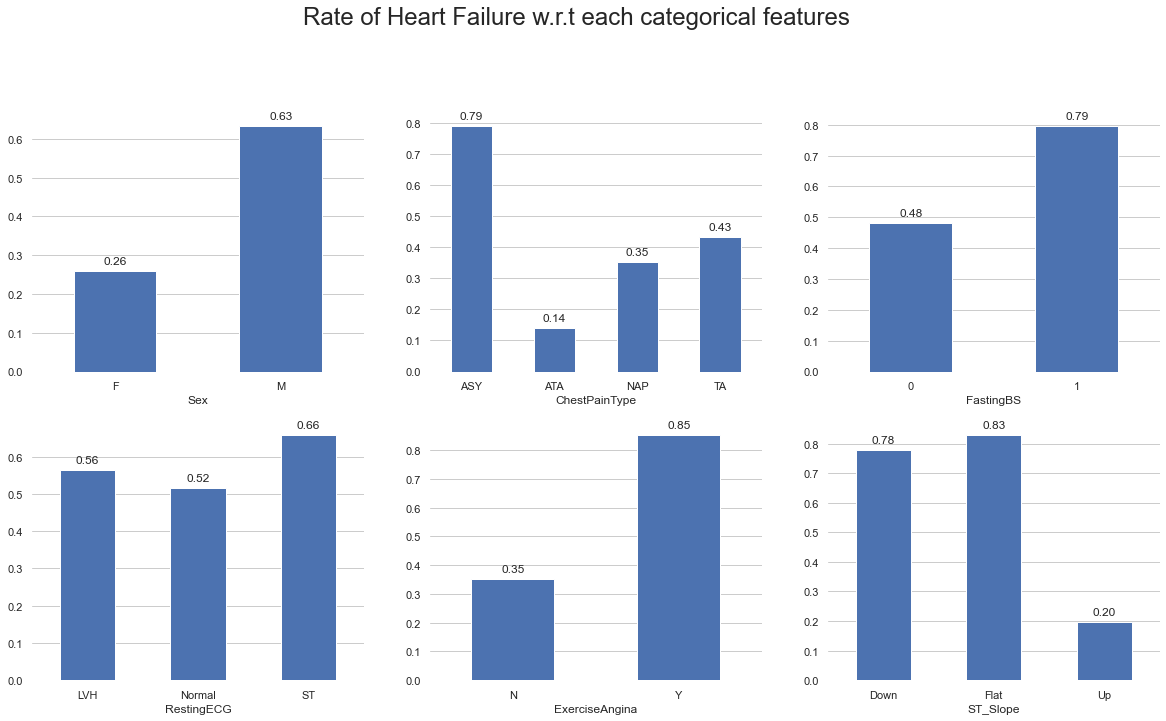

In [8]:
fig = plt.figure(figsize=(18,15))
fig.suptitle("Rate of Heart Failure w.r.t each categorical features", fontsize=24)
for i, col in enumerate(categorical_cols):
    col_pivot = data.pivot_table(index=col, values='HeartDisease').squeeze()
    #print(col_pivot)
    plt.subplot(3,3,i+1)
    ax = col_pivot.plot.bar(rot=0)
    ax.xaxis.get_label().set_fontsize(12)
    bar_annotations(ax)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    
    ax.xaxis.grid(False)
plt.show()

About 62% of male and 27% of female has heart disease

### Explore numerical features

count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


<AxesSubplot:xlabel='Age', ylabel='Count'>

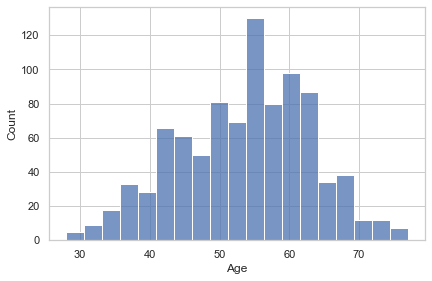

In [9]:
print(data['Age'].describe())
sns.histplot(data=data, x='Age')

We might need to bin the __Age__ column. We will try to train our model with and without binning age.

Let's plot histograms and box plots for all other numerical columns in the dataset.

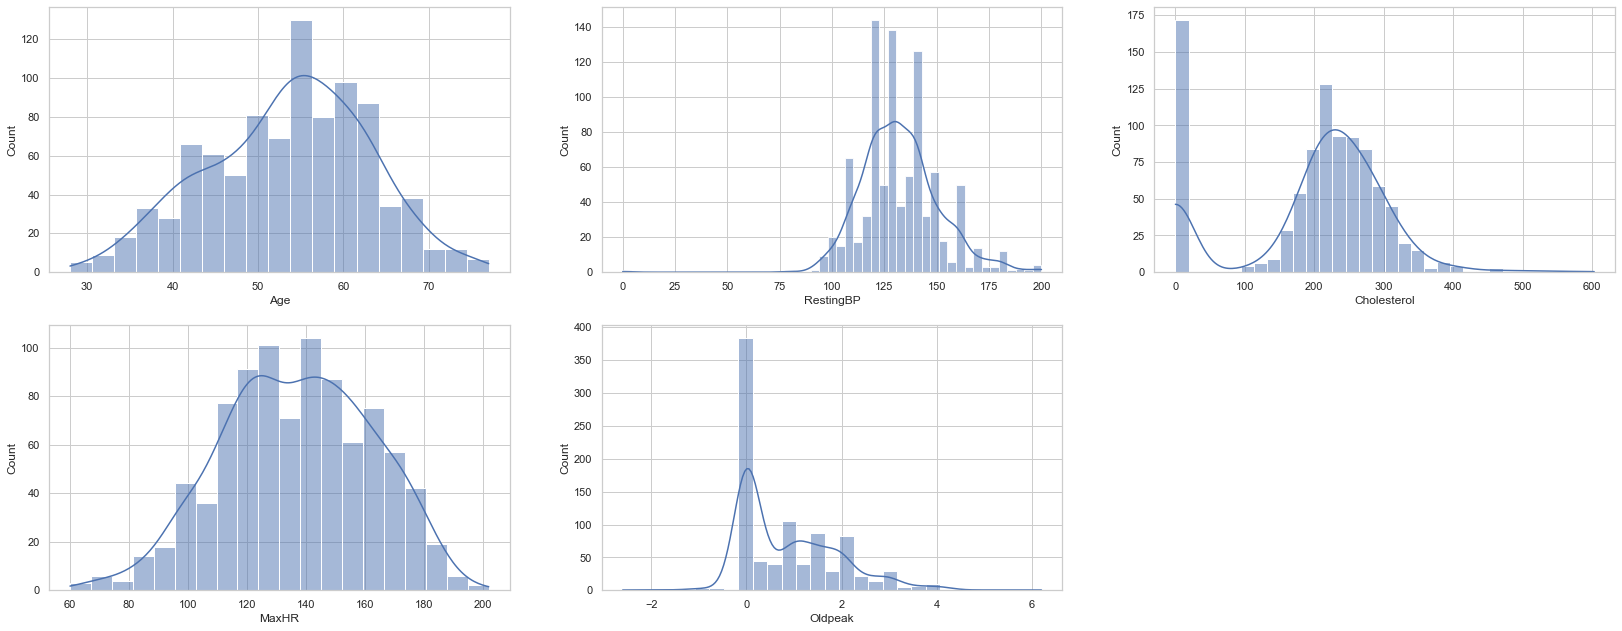

In [10]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(target)

plt.figure(figsize=(25,10))
for index, col in enumerate(numerical_cols):
    plt.subplot(2,len(numerical_cols) - 2 , index + 1)
    sns.histplot(data, x=col, kde=True)

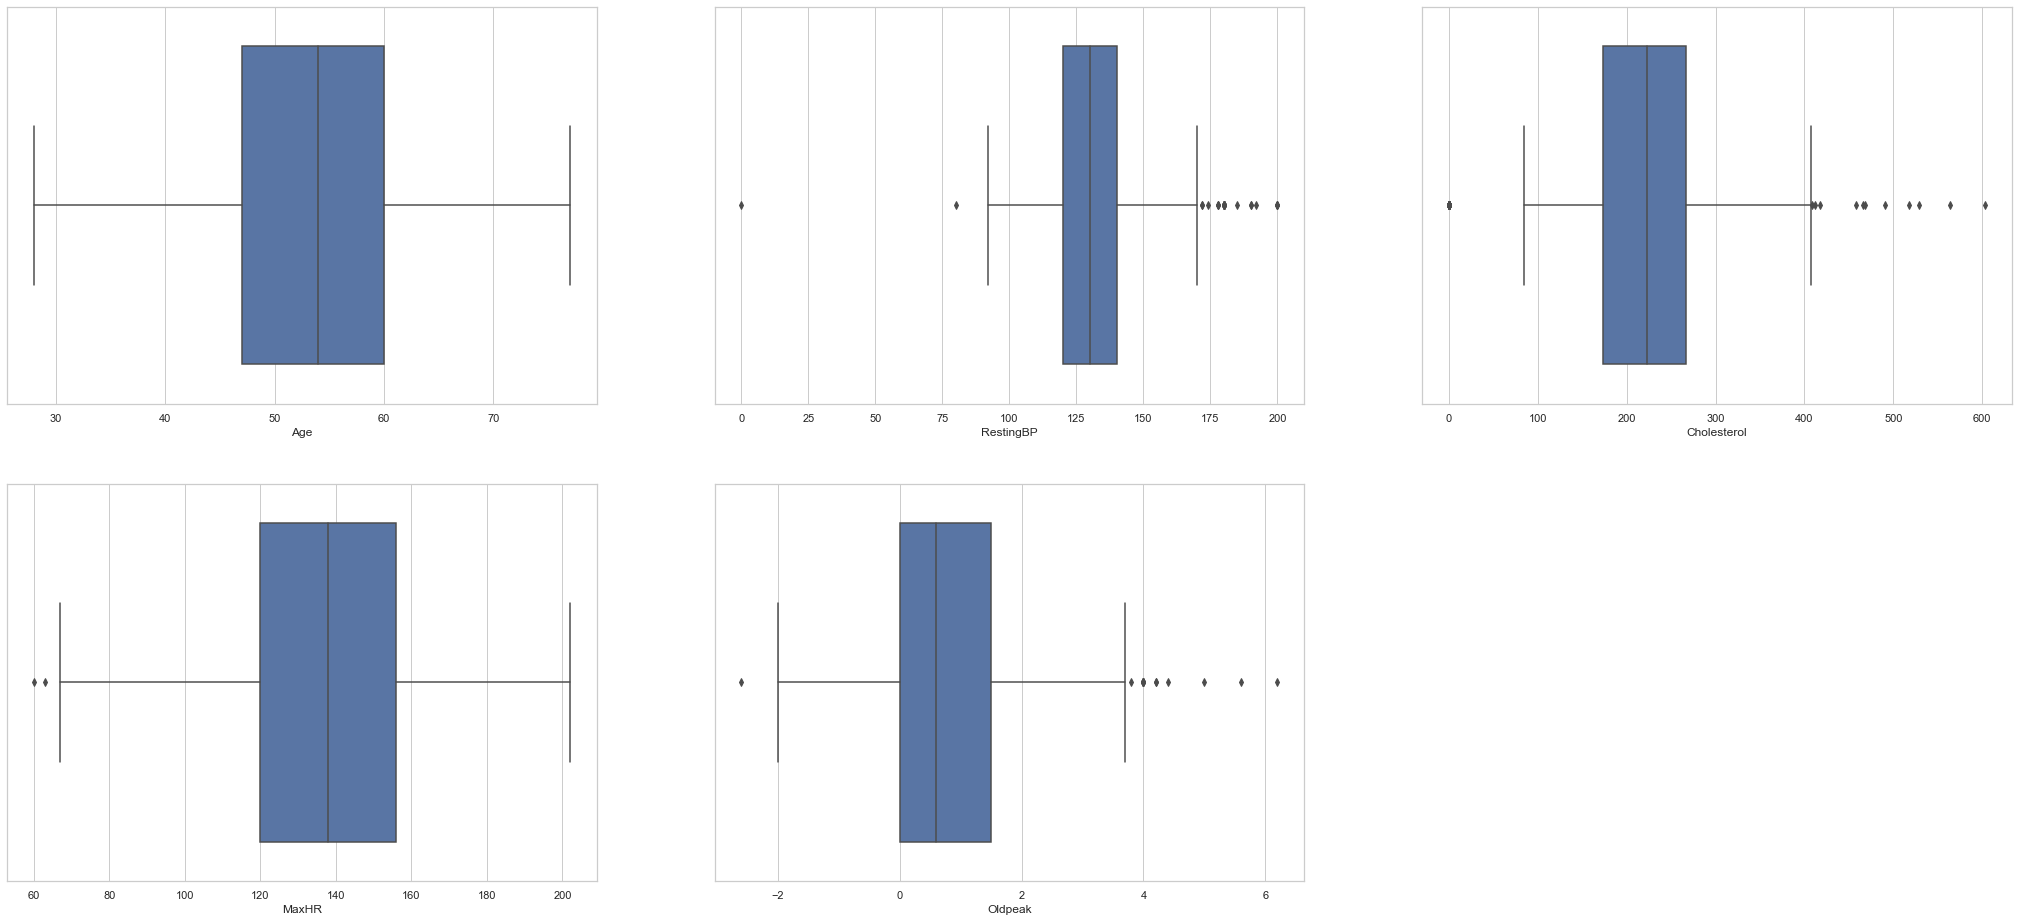

In [11]:
plt.figure(figsize=(32,15))
for index, col in enumerate(numerical_cols):
    plt.subplot(2,len(numerical_cols) - 2 , index + 1)
    sns.boxplot(x = col, data=data)
    

There are some interesting observations here: 

- From the Cholesterol histogram, what's standing out is that there are about 175 patients having Cholesterol recorded 0. It's impossible for a person to have 0 cholesterol. It's unclear if this is on purpose or due to dataset error. For now it's reasonable to conclude that these 0s are equivalent to N/A. We will look into these "0" cholesterol patients and make decision to handle this case.

- Some outliers of each column are:
 - __RestingBP__: > 172 and < 80
 - __Cholesterol__: 0 and > 400 
 - __MaxHR__ : < 65
 - __Oldpeak__ : < -2 and > 3.8
 
Except for 0 case in __Cholesterol__ columns, we will exclude all outliers in these columns

### Investigate 0-Cholesterol cases
Let's extract all the 0-Cholesterol patients and take a closer examination.

In [12]:
zero_cholesterol = data[data['Cholesterol'] == 0]
print(len(zero_cholesterol))
zero_cholesterol.head()

172


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1


Text(0.5, 1.0, 'Heart Disease Counts Among 0-Cholesterol Patients')

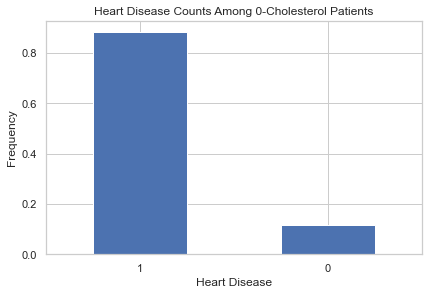

In [13]:
zero_cholesterol['HeartDisease'].value_counts(normalize=True).plot.bar(rot=0)
plt.xlabel('Heart Disease')
plt.ylabel('Frequency')
plt.title('Heart Disease Counts Among 0-Cholesterol Patients')

There is about __88%__ of patients who have "0" cholesterol also has heart disease. How should we handle this case?

We would like to examine if the Cholesterol level is correlated with odds of having heart disease. After excluding 0-Cholesterol patient, we plot a scatter plot of Age vs Cholesterol and labeling Heart Disease. If Cholesterol levels shows some correlations with Heart Disease, we can fill the Cholesterol columns with 0 entry with the mean of non-zero cholesterol patients who have heart disease. Otherwise we can remove these entries.

<AxesSubplot:xlabel='HeartDisease', ylabel='Cholesterol'>

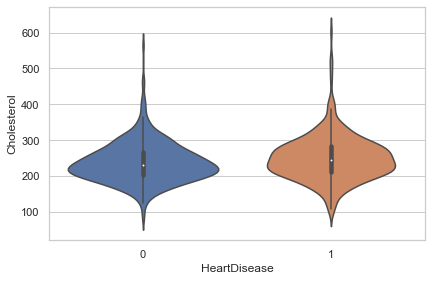

In [14]:
non_zero_cholesterol = data[data['Cholesterol'] > 0]
sns.violinplot(x='HeartDisease', y='Cholesterol', data=non_zero_cholesterol)

Without 0-cholesterol entries, there is no correlation between cholesterol level and rate of heart failure. As seen in the violin plot above, both cases of Heart Disease have similar Cholesterol distribution e.g median and some clusters. 

Hence, there are 3 ways in handling this extreme case and examine which one give better performance for our training model later:
- Leave it as is.
- Replace 0 Cholesterol with mean of all non-zero Cholesterol entries
- Remove these entries

<AxesSubplot:xlabel='Age', ylabel='RestingBP'>

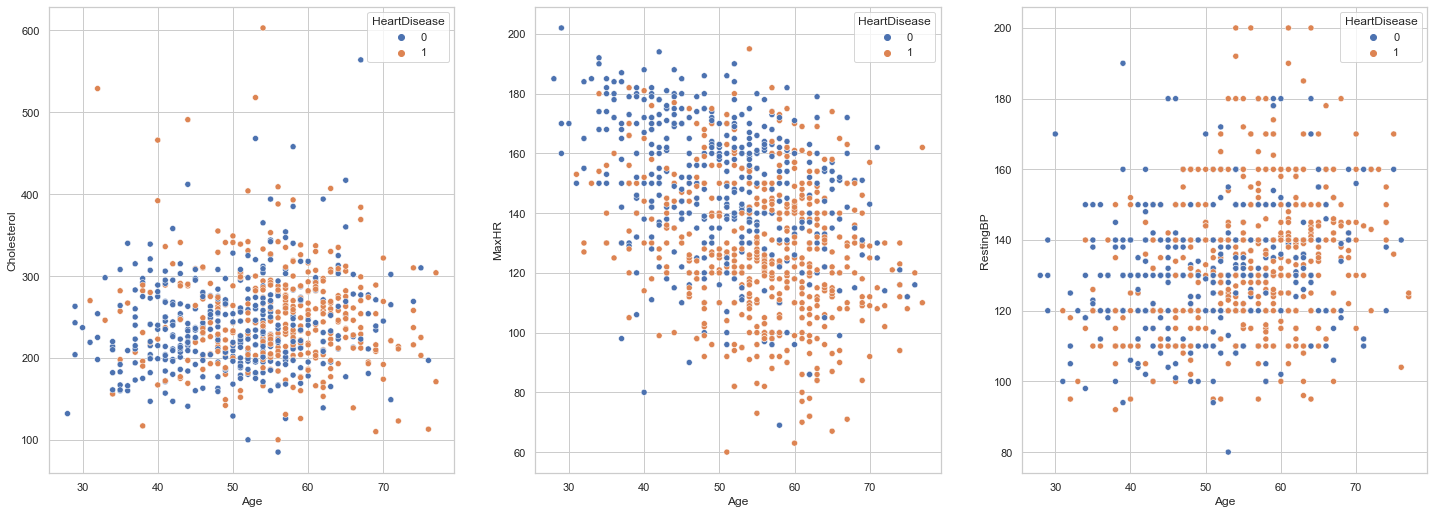

In [15]:
plt.figure(figsize=(22,8))
plt.subplot(1,3,1)
sns.scatterplot(data = non_zero_cholesterol, x='Age', y='Cholesterol', hue='HeartDisease')

plt.subplot(1,3,2)
sns.scatterplot(data = data, x='Age', y='MaxHR', hue='HeartDisease')

plt.subplot(1,3,3)
sns.scatterplot(data = data[data['RestingBP'] > 0], x='Age', y='RestingBP', hue='HeartDisease')

### Correlation Heatmap

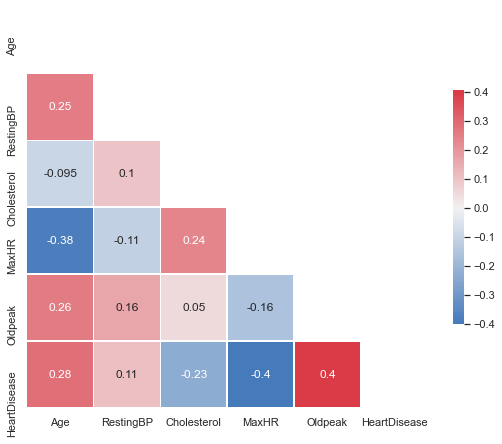

In [16]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    #sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(8, 8))
    cmap = sns.diverging_palette(250, 10, as_cmap=True)


    ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
plot_correlation_heatmap(data)

### Explore target variable

Text(0.5, 1.0, 'Counts of Heart Failures In The Whole Dataset')

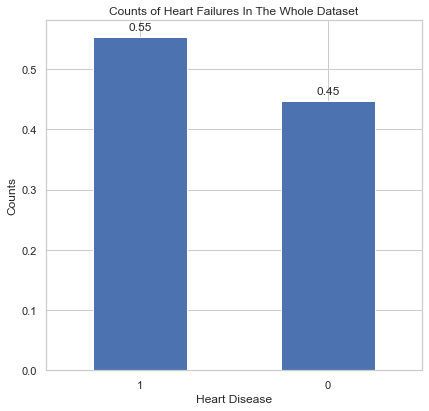

In [17]:
plt.figure(figsize=(6,6))
ax = data['HeartDisease'].value_counts(normalize=True).plot.bar(rot=0)
bar_annotations(ax)
plt.xlabel('Heart Disease')
plt.ylabel('Counts')
plt.title('Counts of Heart Failures In The Whole Dataset')

The number of counts of both classes are quite balanced so we do not need to worry about the case of imbalanced classes

## Data Cleaning

### Excluding/Replace Outliers

In [18]:
def replace_lower_outliers(df):
    df_copy = df.copy()
    Q1 = df_copy.quantile(0.25)
    Q3 = df_copy.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    df_copy[df_copy < lower_bound] = lower_bound
    return df_copy

def replace_upper_outliers(df):
    df_copy = df.copy()
    Q1 = df_copy.quantile(0.25)
    Q3 = df_copy.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5*IQR
    df_copy[df_copy > upper_bound] = upper_bound
    return df_copy

def clean_outliers(df):
    df_clean = df.copy()
    cols_with_outliers = ['RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol']
    
    for col in cols_with_outliers:
        if col != 'Cholesterol':
            df_clean[col] = replace_lower_outliers(df_clean[col])
    
        df_clean[col] = replace_upper_outliers(df_clean[col])
        
    return df_clean


In [19]:
data_clean = clean_outliers(data)
data_clean.shape

(918, 12)

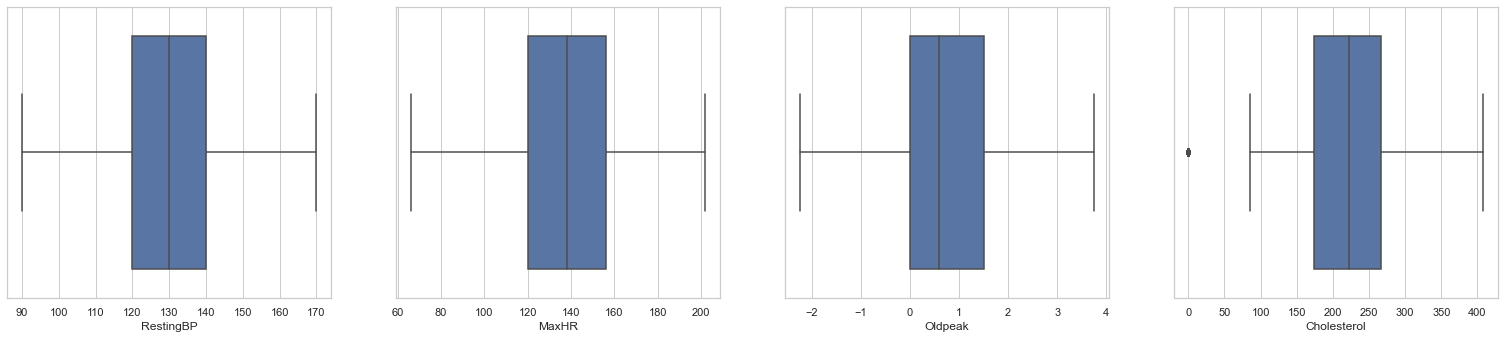

In [20]:
cols_with_outliers = ['RestingBP', 'MaxHR', 'Oldpeak', 'Cholesterol']
plt.figure(figsize=(30,5))
for index, col in enumerate(cols_with_outliers):
    plt.subplot(1,len(numerical_cols) , index + 1)
    sns.boxplot(x = col, data=data_clean)

###  What if: Interporlate Cholesterol column for "0" case

In [21]:
print("Before cleaning: ")
print("There are ", (data_clean['Cholesterol'] == 0).sum(), "cases having 0 Cholesterol")

Before cleaning: 
There are  172 cases having 0 Cholesterol


In [22]:
data_clean.loc[data_clean['Cholesterol'] == 0,'Cholesterol'] = np.NaN
data_clean['Cholesterol'].isnull().sum() #double check

172

In [23]:
#Fill NA with mean()
data_clean['Cholesterol'] = data_clean['Cholesterol'].fillna(np.mean(data_clean['Cholesterol']))
data_clean['Cholesterol'].isnull().sum() #double check

0

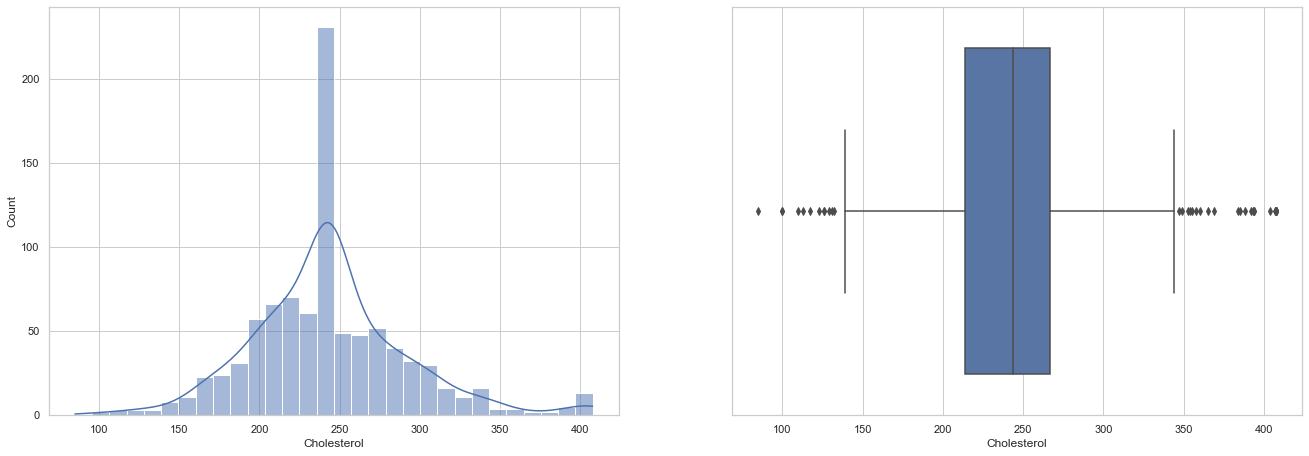

In [24]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1); sns.histplot(data_clean, x='Cholesterol', kde=True)
plt.subplot(1,2,2); sns.boxplot(x='Cholesterol', data=data_clean)
plt.show()

###  What if: Remove "0" in rows in Cholesterol column

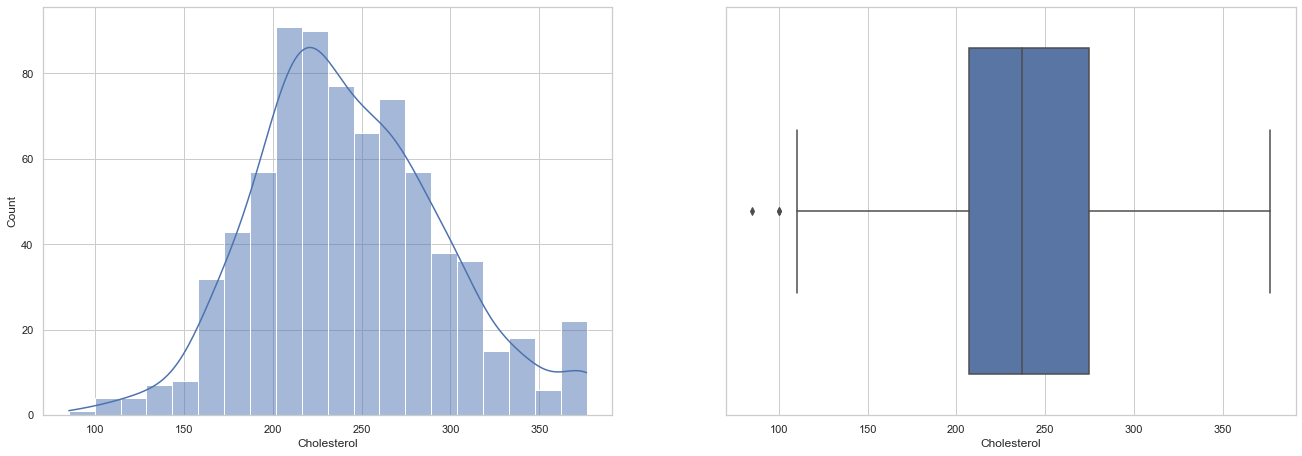

In [25]:
data_clean = data.copy()
#data_clean = clean_outliers(data_clean)
data_clean.loc[data_clean['Cholesterol'] == 0,'Cholesterol'] = np.NaN
data_clean = data_clean.dropna(axis=0)
data_clean = clean_outliers(data_clean)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1); sns.histplot(data_clean, x='Cholesterol', kde=True)
plt.subplot(1,2,2); sns.boxplot(x='Cholesterol', data=data_clean)
plt.show()

### Binning Age column

In [26]:
def process_age(df):
    num_of_bins = 10
    label_names = []
    for i in range(num_of_bins):
        label_names.append("Group {}".format(i+1))
        
    df['Age_categories'] = pd.qcut(df['Age'], q = num_of_bins, labels=label_names)
    df = df.drop('Age', axis=1)
    return df

In [27]:
data_clean = process_age(data_clean)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Sex             746 non-null    object  
 1   ChestPainType   746 non-null    object  
 2   RestingBP       746 non-null    int64   
 3   Cholesterol     746 non-null    float64 
 4   FastingBS       746 non-null    object  
 5   RestingECG      746 non-null    object  
 6   MaxHR           746 non-null    int64   
 7   ExerciseAngina  746 non-null    object  
 8   Oldpeak         746 non-null    float64 
 9   ST_Slope        746 non-null    object  
 10  HeartDisease    746 non-null    int64   
 11  Age_categories  746 non-null    category
dtypes: category(1), float64(2), int64(3), object(6)
memory usage: 71.1+ KB


### Encode categorical columns

In [28]:
data_clean.columns

Index(['Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'Age_categories'],
      dtype='object')

In [29]:
def create_dummies(df, categorical_cols):
    df_encoded = df.copy()
    for col in categorical_cols:
        dummies = pd.get_dummies(df_encoded[col], prefix=col,drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded = df_encoded.drop(col, axis=1)
    return df_encoded


In [30]:
categorical_cols = data_clean.select_dtypes(include=['object', 'category']).columns
data_clean = create_dummies(data_clean, categorical_cols)
data_clean


,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,...,ST_Slope_Up,Age_categories_Group 2,Age_categories_Group 3,Age_categories_Group 4,Age_categories_Group 5,Age_categories_Group 6,Age_categories_Group 7,Age_categories_Group 8,Age_categories_Group 9,Age_categories_Group 10
0,140,289.0,172,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,160,180.0,156,1.0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,130,283.0,98,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,138,214.0,108,1.5,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,150,195.0,122,0.0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,110,264.0,132,1.2,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
914,144,193.0,141,3.4,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
915,130,131.0,115,1.2,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
916,130,236.0,174,0.0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Create a data_prepocessing() function

We will condense all data cleaning steps above into one function

In [31]:
def data_preprocessing(df):
    data_clean = df.copy()
    
    #Interpolate/Remove 0-Cholesterol entries
    #data_clean.loc[data_clean['Cholesterol'] == 0,'Cholesterol'] = np.NaN
    #data_clean['Cholesterol'] = data_clean['Cholesterol'].fillna(np.mean(data_clean['Cholesterol']))
    #data_clean = data_clean.dropna(axis=0)
    
    #Exclude outliers
    data_clean = clean_outliers(data_clean)
     
    #Binning Age column
    #data_clean = process_age(data_clean)
    
    #Feature Scaling
    numerical_cols = data_clean.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = numerical_cols.drop('HeartDisease')
    min_max_scaler = MinMaxScaler()
    data_clean[numerical_cols] = min_max_scaler.fit_transform(data_clean[numerical_cols])
    
    #Encode categorical columns
    data['FastingBS'] = data['FastingBS'].astype('object') #convert to object column
    categorical_cols = data_clean.select_dtypes(include=['object', 'category']).columns
    data_clean = create_dummies(data_clean, categorical_cols)
    
    return data_clean

In [32]:
data_clean = data_preprocessing(data)
data_clean

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,0.244898,0.625,0.708985,0.779412,0.375000,0,1,1,0,0,0,1,0,0,0,1
1,0.428571,0.875,0.441582,0.661765,0.541667,1,0,0,1,0,0,1,0,0,1,0
2,0.183673,0.500,0.694266,0.235294,0.375000,0,1,1,0,0,0,0,1,0,0,1
3,0.408163,0.600,0.524992,0.308824,0.625000,1,0,0,0,0,0,1,0,1,1,0
4,0.530612,0.750,0.478381,0.411765,0.375000,0,1,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.346939,0.250,0.647654,0.485294,0.575000,1,1,0,0,1,0,1,0,0,1,0
914,0.816327,0.675,0.473474,0.551471,0.941667,1,1,0,0,0,1,1,0,0,1,0
915,0.591837,0.500,0.321374,0.360294,0.575000,1,1,0,0,0,0,1,0,1,1,0
916,0.591837,0.500,0.578964,0.794118,0.375000,1,0,1,0,0,0,0,0,0,1,0


## Split into train and test set

This train and test set is fixed as we compare the effectiveness of different models

In [33]:
features = data_clean.columns
features = features.drop(target)

X_train, X_test, y_train, y_test = train_test_split(data_clean[features], data_clean[target], test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)

(734, 15)
(184, 15)


We will train the and compare between the following models:
1. KNN
2. Random Forest
3. Logistic Regression
4. SVC
5. Graident Boosting

## Utitlity functions 

We will create 3 functions and all take __model__ as an argument. 
- __train_model()__ : to train a single model. 
- __train_cv_model()__: to perform cross-validation of a model
- __hyperparameter_tuning()__: to perform hyperparameter tuning of a model

In [34]:
def train_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    #make prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    #Calculate error metrics
    roc_score_train = roc_auc_score(y_train, y_train_pred)
    roc_score_test = roc_auc_score(y_test, y_test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    
    print("Train ROC Score: ", roc_score_train)
    print("Test ROC Score: ", roc_score_test)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], ls='--')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return model, roc_score_test

def train_cv_model(model, df, features, target):
    kf = KFold(10, shuffle=True, random_state=10)

    roc_scores = cross_validate(model, df[features], df[target], scoring='roc_auc', return_train_score=True, cv=kf)
    mean_test_roc_score = np.mean(roc_scores['test_score'])
    mean_train_roc_score = np.mean(roc_scores['train_score'])
   
    #print(roc_scores)
    print("Mean Train ROC Score: ", mean_train_roc_score)
    print("Mean Test ROC Score: ", mean_test_roc_score)
    return

def hyperparameter_tuning(model, hyperparameters, df, features, target):
    kf = KFold(10, shuffle=True, random_state=10)
    grid = GridSearchCV(model, param_grid=hyperparameters, scoring='roc_auc', cv = kf)
    grid.fit(df[features], df[target])
    best_params = grid.best_params_
    best_score = grid.best_score_

    print("Best Parameters:", best_params)
    print("Best scores:", best_score)
    
    return grid.best_estimator_

## KNN

Train ROC Score:  0.8766974754726011
Test ROC Score:  0.8711302211302211
Sensitivity:  0.8909090909090909
Specificity:  0.8513513513513513


(KNeighborsClassifier(), 0.8711302211302211)

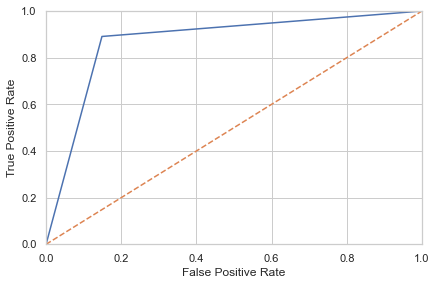

In [35]:
knn = KNeighborsClassifier(n_neighbors=5)
train_model(knn, X_train, X_test, y_train, y_test)

### Cross-validation with KNN

In [36]:
train_cv_model(knn, data_clean, features, target)

Mean Train ROC Score:  0.9597668249786141
Mean Test ROC Score:  0.9036107707959944


### Hyperparameter Tuning with KNN

In [37]:
hyperparameters = {
    'n_neighbors':[2,3,5,6,7,8,9,10],
    'algorithm': ['auto','brute', 'kd_tree', 'ball_tree'],
    'weights': ['uniform', 'distance']
   
}

best_knn = hyperparameter_tuning(knn, hyperparameters, data_clean, features, target)

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
Best scores: 0.9190078144487213


### Finalized KNN

Train ROC Score:  1.0
Test ROC Score:  0.8847665847665848
Sensitivity:  0.9181818181818182
Specificity:  0.8513513513513513


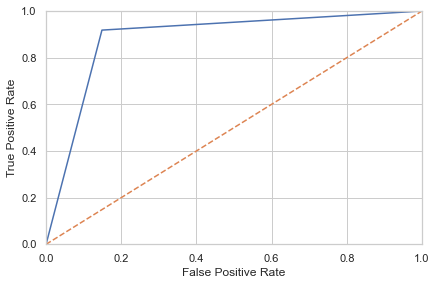

In [38]:
best_knn, knn_roc = train_model(best_knn, X_train, X_test, y_train, y_test)

## RandomForest 

Train ROC Score:  1.0
Test ROC Score:  0.8893120393120393
Sensitivity:  0.9272727272727272
Specificity:  0.8513513513513513


(RandomForestClassifier(n_estimators=200, random_state=1), 0.8893120393120393)

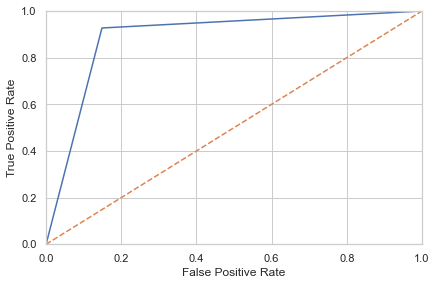

In [39]:
rf = RandomForestClassifier(n_estimators= 200, random_state=1)
train_model(rf, X_train, X_test, y_train, y_test)

### Cross-validation with RandomForest

In [40]:
train_cv_model(rf, data_clean, features, target)

Mean Train ROC Score:  1.0
Mean Test ROC Score:  0.931122059117318


### Hyperparameter Tuning with RandomForest

In [41]:
hyperparameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10],
    'min_samples_split': [2,3,4,5,6,7],
    'min_samples_leaf': [1, 3, 5, 7],
    'max_features':['sqrt', 'log2'],
   
}
best_rf = hyperparameter_tuning(rf, hyperparameters, data_clean, features, target)

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7}
Best scores: 0.9326868980798254


### Finalized RandomForest model

Train ROC Score:  0.9572116535056233
Test ROC Score:  0.8893120393120393
Sensitivity:  0.9272727272727272
Specificity:  0.8513513513513513


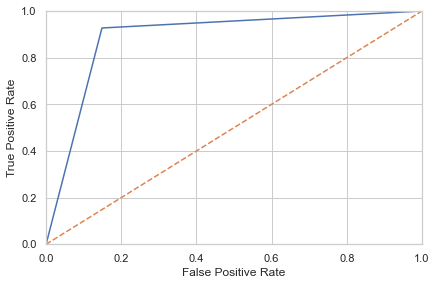

In [42]:
best_rf, rf_roc = train_model(best_rf, X_train, X_test, y_train, y_test)

### Features Importance (on both train and test set)

In [43]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_rf, X_test, y_test, n_repeats = 30, scoring='roc_auc', random_state=0)
test_features_imp = pd.DataFrame()
test_features_imp['Features'] = features
test_features_imp['Importance Mean'] = r.importances_mean
test_features_imp = test_features_imp.sort_values(by='Importance Mean', ascending=False)

r = permutation_importance(best_rf, X_train, y_train, n_repeats = 30, scoring='roc_auc', random_state=0)
train_features_imp = pd.DataFrame()
train_features_imp['Features'] = features
train_features_imp['Importance Mean'] = r.importances_mean
train_features_imp = train_features_imp.sort_values(by='Importance Mean', ascending=False)


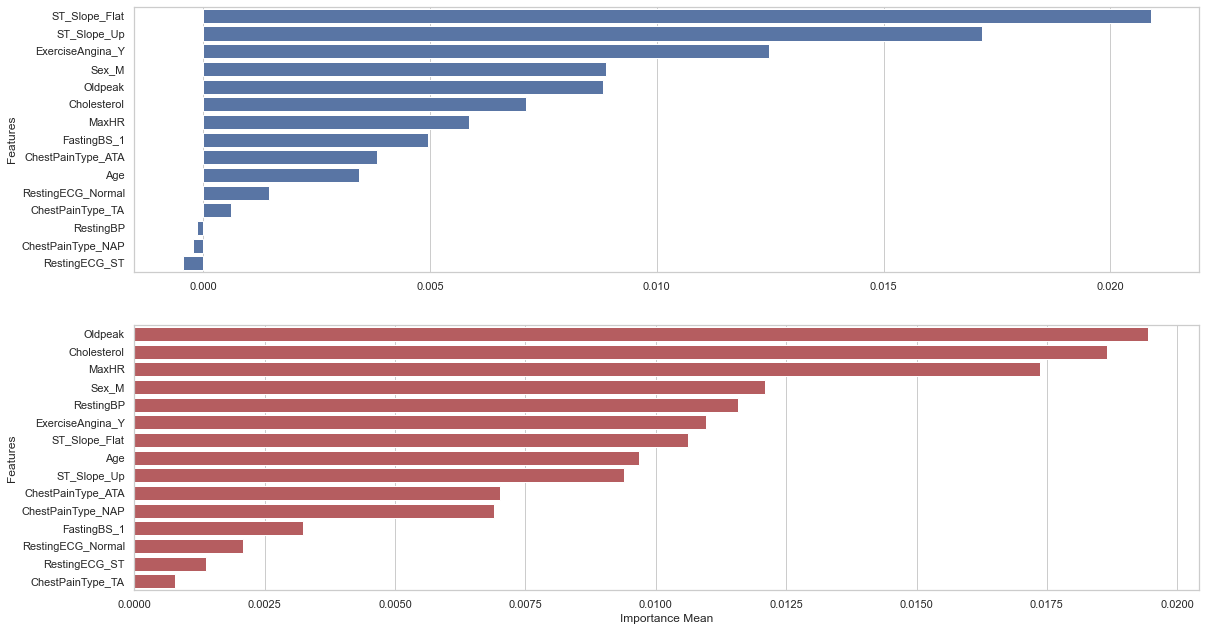

In [44]:
plt.figure(figsize=(17,10))
plt.subplot(2,1,1)
ax1 = sns.barplot(x='Importance Mean', y='Features', data=test_features_imp, orient='h', color='b')
ax1.set_xlabel('')
plt.subplot(2,1,2)
ax2 = sns.barplot(x='Importance Mean', y='Features', data=train_features_imp, orient='h', color='r')


## Logistic Regression

Train ROC Score:  0.8591095357741086
Test ROC Score:  0.8960687960687962
Sensitivity:  0.9272727272727272
Specificity:  0.8648648648648649


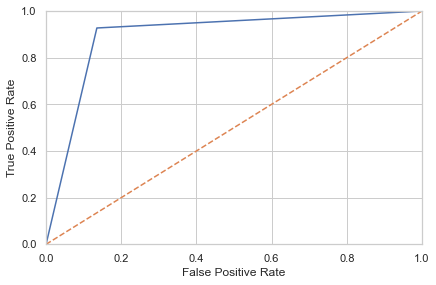

In [45]:
lr = LogisticRegression(solver='liblinear')
lr, lr_roc = train_model(lr, X_train, X_test, y_train, y_test)

### Cross-validation with Logistic Regression

In [46]:
train_cv_model(lr, data_clean, features, target)

Mean Train ROC Score:  0.9325360209949322
Mean Test ROC Score:  0.9236828391444065


## Support Vector Machine (SVC)

Train ROC Score:  0.8821862287628619
Test ROC Score:  0.9006142506142507
Sensitivity:  0.9363636363636364
Specificity:  0.8648648648648649


(SVC(), 0.9006142506142507)

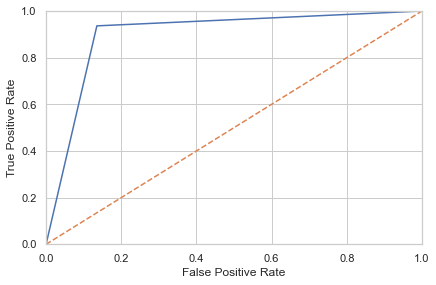

In [47]:
svc = SVC()
train_model(svc, X_train, X_test, y_train, y_test)

### Cross-validation with SVC

In [48]:
train_cv_model(svc, data_clean, features, target)

Mean Train ROC Score:  0.9541757453082662
Mean Test ROC Score:  0.9267555229950595


### Hyperparameter tuning with SVC

In [49]:
hyperparameters = {
    'kernel': ['rbf','linear','sigmoid','poly']
}

best_svc = hyperparameter_tuning(svc, hyperparameters, data_clean, features, target)

Best Parameters: {'kernel': 'rbf'}
Best scores: 0.9267555229950595


### Finalized SVC

Train ROC Score:  0.8821862287628619
Test ROC Score:  0.9006142506142507
Sensitivity:  0.9363636363636364
Specificity:  0.8648648648648649


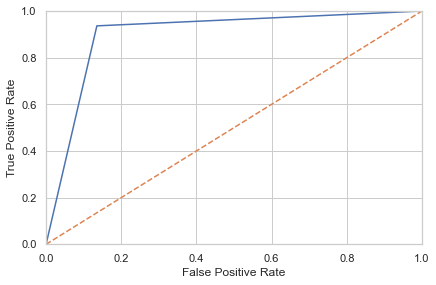

In [50]:
best_svc, svc_roc = train_model(best_svc, X_train, X_test, y_train, y_test)

## Gradient Boosting Classifier

Train ROC Score:  0.9419044627901412
Test ROC Score:  0.8937346437346438
Sensitivity:  0.9090909090909091
Specificity:  0.8783783783783784


(GradientBoostingClassifier(random_state=1), 0.8937346437346438)

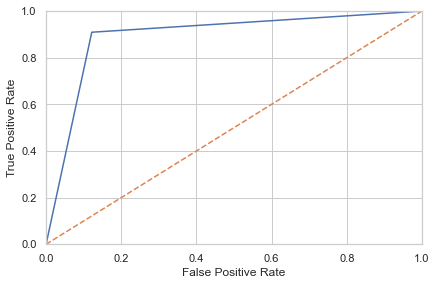

In [51]:
gb = GradientBoostingClassifier(random_state=1)
train_model(gb, X_train, X_test, y_train, y_test)

### Cross-validation with Gradient Boosting

In [52]:
train_cv_model(gb, data_clean, features, target)

Mean Train ROC Score:  0.987942594620483
Mean Test ROC Score:  0.9295072216299813


### Hyperparameter tuning with Gradient Boosting

In [53]:
hyperparameters = {
    'max_depth': [3,4,5],
    'learning_rate':[0.1, 0.05, 0.2, 0.4],
    'subsample':[1.0, 0.95, 0.85],
    'min_samples_split':[2,4,6,8],
    'min_samples_leaf':[1,2,3,5]
}
best_gb = hyperparameter_tuning(gb, hyperparameters, data_clean, features, target)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'subsample': 1.0}
Best scores: 0.9358482291834246


### Finalized GradientBoosting

Train ROC Score:  0.908837341469251
Test ROC Score:  0.8960687960687962
Sensitivity:  0.9272727272727272
Specificity:  0.8648648648648649


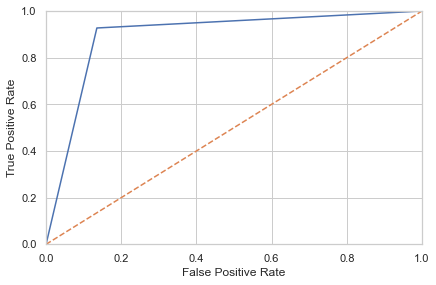

In [54]:
#best_gb = GradientBoostingClassifier(learning_rate=0.05, min_samples_split=6)
best_gb, gb_roc = train_model(best_gb, X_train, X_test, y_train, y_test)

## Model Comparison

Text(0.5, 1.0, 'ROC score vs Different Machine Learning Models')

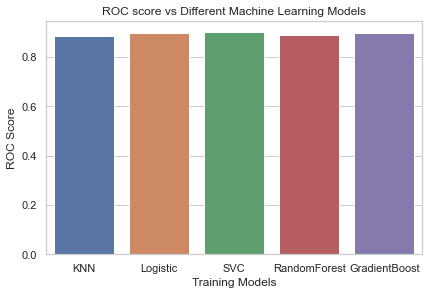

In [56]:
x = ['KNN', 'Logistic', 'SVC', 'RandomForest', 'GradientBoost']
y = [knn_roc, lr_roc, svc_roc, rf_roc, gb_roc]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel('Training Models')
ax.set_ylabel('ROC Score')
ax.set_title('ROC score vs Different Machine Learning Models')
                